<font size="8"> **Plotting results from species distribution models for crabeaters seals** </font>  
We will plot the crabeater seal distribution as predicted by four different species distribution model algorithms:  
1. Generalised Additive Models (GAMs)  
2. Maximum Entrophy Modeling (Maxent)  
3. Random Forests (RFs)  
4. Boosted Regression Trees (BRTs)
  
Additionally, an ensemble prediction is included. The ensemble result is simply the mean probability of the four algorithms listed above.

Given the reported influence on crabeater distribution, plots will include the following information:
- Mean sea ice extent (only the edge will be shown)  
- Continental shelf 1,000 m depth contour around the Antarctic continent)  
- Mean position of the southern boundary of the Antarctic Circumpolar Current (ACC)  
  
Distributions are plotted separately for November and December because environmental conditions differ between these two months, and because they represent two different life stages for crabeaters: breeding period (November) and post-breeding (December).

# Loading libraries

In [2]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))
#Data manipulation and analysis
import xarray as xr
import pandas as pd
import numpy as np
from itertools import cycle
#Spatial data
import geopandas as gp
from shapely.geometry import box
#Data visualisation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
import string
#Accessing model data
import intake
#Collection of useful functions developed for this project
# import UsefulFunctions as uf
#Dealing with paths to folders/files
from glob import glob
#Parallelising work
from dask.distributed import Client

# Loading Indian sectors mask
Since our area of interest includes the East and Central Indian sectors, we will apply a mask to the data prior to calculating the mean for each variable.

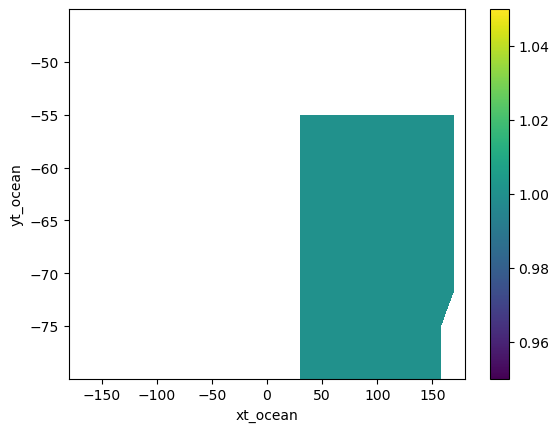

In [3]:
#All variables except velocity
measo = xr.open_dataarray('/g/data/vf71/la6889/Chapter2_Crabeaters/MEASO/MEASO_mask.nc')
#Renaming dimensions to match model data
measo = measo.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'}).sel(yt_ocean = slice(-90, -45))
#Subsetting both masks
measo_ind = xr.where((measo >= 13) & (measo <= 19) & (measo.yt_ocean <= -55), 1, np.nan)
#Checking results
measo_ind.plot()

# Defining output folder

In [4]:
out_folder = '/g/data/vf71/la6889/Chapter2_Crabeaters/Mean_conditions_plot'

# Connecting to the `intake` catalog
First, we will start a cluster with multiple cores to make analysis faster. Remember the number of CPUs cannot exceed the CPUs you have access to.

In [5]:
client = Client()

Now we can connect to the `intake` catalog.

In [6]:
catalog = intake.cat.access_nri

# Accessing sea ice data from ACCESS-OM2-01

We will now access the model outputs between November 1981 and December 2013 (period of study). For these calculations, we use monthly sea ice concentration outputs from the fourth cycle of ACCESS-OM2-01 (experiment name `01deg_jra55v140_iaf_cycle4`).

In [6]:
#Loading data
var_ice = uf.getACCESSdata_SO('aice_m', '1981-10', '2014-01', freq = '1mon', 
                              catalog = catalog, minlat = -80, 
                              exp = '01deg_jra55v140_iaf_cycle4', ice_data = True)

#Ensuring data is selected for the time period and area of interest
var_ice = var_ice.sel(time = slice('1981-11', '2013-12'),
                      yt_ocean = slice(-80, -55))

#Transforming longitudes so their range is +/-180 degrees
var_ice = uf.corrlong(var_ice)

#Checking result
var_ice

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.DataArray 'aice_m' (time: 386, yt_ocean: 557, xt_ocean: 3600)> Size: 3GB
dask.array<getitem, shape=(386, 557, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 3kB 1981-11-30 12:00:00 ... 2013-12-31 12:00:00
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 29kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

# Calculating mean sea ice extent over study period

In [7]:
#Calculating mean sea ice extent for November and December in East Antarctica
mean_var = (var_ice.groupby('time.month').mean('time').sel(month = slice(11, 12)).
            where(measo_ind == 1, drop = True))
#Checking results
mean_var

<xarray.DataArray 'aice_m' (month: 2, yt_ocean: 557, xt_ocean: 1400)> Size: 6MB
dask.array<where, shape=(2, 557, 1400), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 11kB 30.05 30.15 30.25 ... 169.8 169.9 170.0
  * month     (month) int64 16B 11 12
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

# Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is under $10\%$. This is a multistep process:
1. Identify pixels where SIC is greater or equal to 0.1, and change value to 1,
2. Calculate cumulate sum along y axis,
3. Apply mask to remove original `NaN` values from cumulative sums.

This will result in pixels with the highest value along the y axis to be identified as the sea ice edge. 

In [8]:
#Assign a value of 1 to any areas where SIC is at least 0.1
ice_10 = xr.where(mean_var >= 0.1, 1, np.nan)

#Adding all cells along y axis. Masking out NA values
ice_10 = ice_10.cumsum(dim = 'yt_ocean', skipna = True).where(~np.isnan(ice_10))

#Finding cells with highest value along y axis. This identifies the ice edge at each longitude.
ice_10 = xr.where(ice_10 == ice_10.max('yt_ocean'), 1, 0).where(~np.isnan(mean_var))

#Saving results
ice_10.to_netcdf(os.path.join(out_folder, 'mean_sea_ice_extent.nc'))

In [8]:
#Checking result for November
mean_var.sel(month = 11).plot()
ice_10.sel(month = 11).plot.contour(levels = [0])

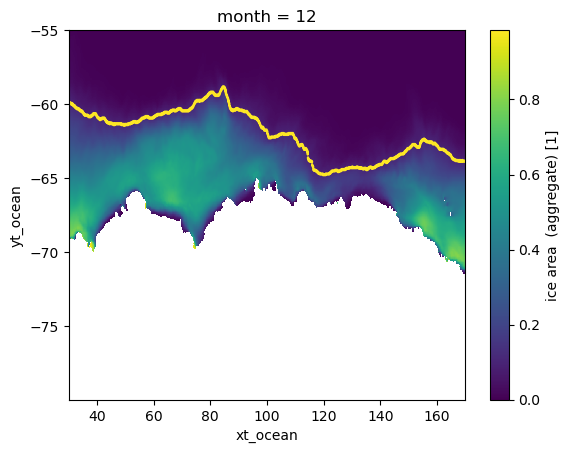

In [10]:
#Checking result for December
mean_var.sel(month = 12).plot()
ice_10.sel(month = 12).plot.contour(levels = [0])

## Loading sea ice edge to avoid calculating again

In [7]:
ice_10 = xr.open_dataarray(os.path.join(out_folder, 'mean_sea_ice_extent.nc'))

# Loading regridded GEBCO bathymetry file
We will load the regridded GEBCO bathymetry that was used to create the bathymetry for the ACCESS-OM2-01 model.

In [8]:
#Loading GEBCO bathymetry
bathy = xr.open_dataarray('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/topog.nc')

#Loading area data from ACCESS model to use as target grid
area = catalog['01deg_jra55v140_iaf_cycle4'].search(variable = 'area_t').to_dask()['area_t']

#Assigning coordinate values to replace indices
bathy.coords['xx'] = area['xt_ocean'].values
bathy.coords['yy'] = area['yt_ocean'].values

#Rename coordinate variables so they match model data and subsetting the Southern Ocean
bathy = bathy.rename(({'xx':'xt_ocean', 'yy':'yt_ocean'})).sel(yt_ocean = slice(-80, -55))

#Ensuring longitude values range between +/-180
bathy = uf.corrlong(bathy).where(measo_ind == 1, drop = True)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [ ]:
#Converting to binaty mask
bathy_1000 = xr.where(bathy <= 1000, 1, 0).where(~np.isnan(bathy))

#Checking results
bathy_1000.plot.contour(levels = [0])

#Saving results
bathy_1000.to_netcdf(os.path.join(out_folder, 'bathy_1000m.nc'))

## Loading 1000 m depth contour to avoid calculating again

In [15]:
bathy_1000 = xr.open_dataarray(os.path.join(out_folder, 'bathy_1000m.nc'))

# Transform ACCESS-OM2-01 grid to dataframe

In [11]:
area_df = bathy_1000.to_dataframe().reset_index()
area_df.drop(columns = 'depth', inplace = True)
area_df = area_df.round({'yt_ocean': 3, 'xt_ocean': 3})
area_df.head()

,yt_ocean,xt_ocean
0,-79.968,30.05
1,-79.968,30.15
2,-79.968,30.25
3,-79.968,30.35
4,-79.968,30.45


In [12]:
#Getting number of times month has to be repeated
rows_month = area_df.shape[0]

#Bind static variables by row
area_df = pd.concat([area_df, area_df], axis = 0)

#Add a month column to bind data frame
area_df['month'] = [11]*rows_month + [12]*rows_month

#Check results
area_df.head()

,yt_ocean,xt_ocean,month
0,-79.968,30.05,11
1,-79.968,30.15,11
2,-79.968,30.25,11
3,-79.968,30.35,11
4,-79.968,30.45,11


## Loading weights for model ensemble
Since not all SDMs performed equally well, the final ensemble will be calculated as a weighted mean of the four SDMs used in this project: GAMs, Maxent, BRTs and RFs. The weighting will depend on three model performance metrics: area under the the receiver operating curve ($AUC_{ROC}$), area under the precisison-recall gain curve ($AUC_{PRG}$) and the Pearson correlation between the model predictions and the testing dataset.

In [13]:
model_eval = pd.read_csv('../SDM_outputs/model_evaluation.csv')
model_eval

,model,env_trained,auc_roc,auc_prg,pear_cor,pear_norm_weights,maxSSS
0,GAM,mod_match_obs,0.633055,0.402899,0.103877,0.096804,0.523297
1,GAM,full_access,0.648113,0.532575,0.119335,0.078205,0.528074
2,GAM,observations,0.625150,0.260761,0.097667,0.046861,0.478964
3,Maxent,mod_match_obs,0.641700,0.530681,0.052916,0.000000,NaN
4,Maxent,full_access,0.682595,0.849451,0.078392,0.000000,NaN
5,Maxent,observations,0.692890,0.695507,0.078910,0.000000,NaN
6,RandomForest,mod_match_obs,0.853296,0.852542,0.324360,0.515622,0.119753
7,RandomForest,full_access,0.947518,0.991557,0.379160,0.574494,0.049624
8,RandomForest,observations,0.918195,0.972477,0.317180,0.595272,0.043210
9,BoostedRegressionTrees,mod_match_obs,0.818797,0.833306,0.256950,0.387573,0.080477


# Predicted distribution ACCESS-OM2-01 matches observations

In [41]:
#Providing location of SDM outputs
mod_match_files = ['../SDM_outputs/GAM/Mod_match_obs/mean_pred_match_obs.csv',
                   '../SDM_outputs/Maxent/Mod_match_obs/reduced_Maxent_model/mean_pred_match_obs.csv', 
                   '../SDM_outputs/RandomForest/Mod_match_obs/mean_pred_match_obs.csv',
                   '../SDM_outputs/BoostedRegressionTrees/Mod_match_obs/mean_pred_match_obs.csv']

#Extracting algorithm name
models = [f.split('/')[2] for f in mod_match_files]

In [26]:
#Loading data frames with predictions
mod_match_obs_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(mod_match_files)]
#Create dataset
mod_match_obs = uf.ds_sdm(mod_match_obs_df, bathy_1000, 
                          model_eval[model_eval.env_trained == 'mod_match_obs'],
                          'pear_norm_weights')
#Saving dataset
mod_match_obs.to_netcdf(os.path.join(out_folder, 'mod_match_obs.nc'))

In [42]:
mod_match_obs = xr.open_dataset(os.path.join(out_folder, 'mod_match_obs.nc'))

In [43]:
#Creating binary outputs
bin_mod_match_obs = mod_match_obs.sel(model = 'Ensemble')
bin_mod_match_obs = xr.where(bin_mod_match_obs > 0.1516, 1, 0)

## Predicted distribution ACCESS-OM2-01 full suite

In [38]:
mod_files = ['../SDM_outputs/GAM/Mod_full/mean_pred_mod.csv',
             '../SDM_outputs/Maxent/Mod_full/initial_Maxent_model/mean_pred_ACCESS.csv',
             '../SDM_outputs/RandomForest/Mod_full/mean_pred_ACCESS.csv',
             '../SDM_outputs/BoostedRegressionTrees/Mod_full/mean_pred_ACCESS.csv']

In [28]:
#Loading data frames with predictions
mod_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(mod_files)]
#Create dataset
mod = uf.ds_sdm(mod_df, bathy_1000, model_eval[model_eval.env_trained == 'full_access'],
                'pear_norm_weights')
#Saving dataset
mod.to_netcdf(os.path.join(out_folder, 'full_mod.nc'))

In [39]:
mod = xr.open_dataset(os.path.join(out_folder, 'full_mod.nc'))

In [40]:
#Creating binary outputs
bin_mod = mod.sel(model = 'Ensemble')
bin_mod = xr.where(bin_mod > 0.0964, 1, 0)

## Predicted distribution observations

In [35]:
obs_files = ['../SDM_outputs/GAM/Obs/mean_pred_obs.csv',
             '../SDM_outputs/Maxent/Obs/reduced_Maxent_model/mean_pred_obs.csv',
             '../SDM_outputs/RandomForest/Obs/mean_pred_obs.csv',
             '../SDM_outputs/BoostedRegressionTrees/Obs/mean_pred_obs.csv']

In [29]:
#Loading data frames with predictions
obs_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(obs_files)]
#Create dataset
obs = uf.ds_sdm(obs_df, bathy_1000, model_eval[model_eval.env_trained == 'observations'],
                'pear_norm_weights')
#Saving dataset
obs.to_netcdf(os.path.join(out_folder, 'obs.nc'))

In [36]:
obs = xr.open_dataset(os.path.join(out_folder, 'obs.nc'))

In [37]:
#Creating binary outputs
bin_obs = obs.sel(model = 'Ensemble')
bin_obs = xr.where(bin_obs > 0.0746, 1, 0)

## Plotting results of SDM algorithms

### November predictions

/jobfs/145569806.gadi-pbs/ipykernel_2685587/2486027730.py:112: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../SDM_outputs/November_results.tif', dpi = 300, bbox_inches = 'tight',
/jobfs/145569806.gadi-pbs/ipykernel_2685587/2486027730.py:112: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../SDM_outputs/November_results.tif', dpi = 300, bbox_inches = 'tight',
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


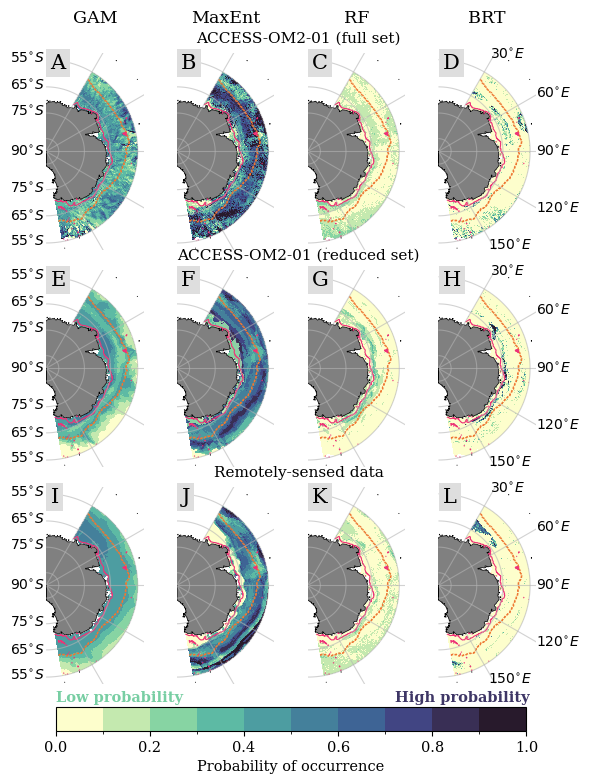

In [34]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [6.75, 10], constrained_layout = True)

#Setting levels for colorbar
levels = np.arange(0, 1.1, 0.1)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10.5

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Creating counter for plotting loop
#Defining SDM algorithms
SDM = ['GAM', 'MaxEnt', 'RF', 'BRT']

#Defining datasets to be plotted
trained_by = ['ACCESS-OM2-01 (full set)', 'ACCESS-OM2-01 (reduced set)', 'Remotely-sensed data']

#Index to loop through each subplot
counter = zip(np.repeat(np.arange(0, len(trained_by)), len(SDM)), cycle(np.arange(0, len(SDM))))

#Create grid
gs = gridspec.GridSpec(nrows = len(trained_by), ncols = len(SDM), wspace = 0., hspace = 0.1)

#Initiliase dictionary to store axes
ax = {}

#Creating plot using loop
for i, j in counter:
    ax[i, j] = fig.add_subplot(gs[i, j], projection = projection)
    #Select data based on column index
    if i == 0:
        da = mod.November
    elif i == 1:
        da = mod_match_obs.November
    elif i == 2:
        da = obs.November
        
    #Plot maps
    p1 = da.isel(model = j).plot.pcolormesh(ax = ax[i, j], colors = cm.cm.deep, 
                                            levels = levels, add_colorbar = False,
                                            transform = ccrs.PlateCarree())
    ice_10.sel(month = 11).plot.contour(levels = [0], colors = '#ee7733', linewidths = 1.1,
                                        ax = ax[i, j], linestyles = 'dotted',
                                        transform = ccrs.PlateCarree(), add_colorbar = False)
    bathy_1000.plot.contour(levels = [0], colors = '#ee3377', ax = ax[i, j], linewidths = 0.75,
                            transform = ccrs.PlateCarree(), add_colorbar = False)

    if j == 0:
        #Adding gridline labels - latitudes - First column only
        plt.text(-0.37, 0.95, '$55^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.81, '$65^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.68, '$75^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.48, '$90^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.29, '$75^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.15, '$65^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.02, '$55^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
    elif j == len(trained_by):
        #Adding gridline labels - longitudes - Last column only
        plt.text(0.53, 0.97, '$30^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.77, '$60^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.48, '$90^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.19, '$120^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(0.51, 0., '$150^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)

    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i, j].spines.values()]
    #Drawing gridlines
    gl = ax[i, j].gridlines(crs = ccrs.PlateCarree(), draw_labels = False, y_inline = False, 
                            color = "#b4b4b4", alpha = 0.6)
    #Specifying location of y gridlines
    gl.ylocator = mticker.FixedLocator([-55, -65, -75, -85])
    
    #Set titles for each map
    if i == 0:
        ax[i, j].set_title(f'{SDM[j]}\n', y = 1.01)
    if j == 1:
         ax[i, j].text(1.25, 1.07, f'{trained_by[i]}', horizontalalignment = 'center', 
                       fontsize = 11, verticalalignment = 'center', 
                       transform = ax[i, j].transAxes)
    
#Add land
[ax[a].add_feature(land_50m) for a in ax]
#Set extent shown in map
[ax[a].set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree()) for a in ax]

#Colorbar settings
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.03, label = 'Probability of occurrence')

#Add labels to improve readability
#Get colormap to extract colors for labels
# cmap = mcm.get_cmap(cm.cm.deep)
cmap = plt.get_cmap(cm.cm.deep)
cb.ax.text(0., 1.25, 'Low probability', color = cmap(0.25), fontweight = 'bold')
cb.ax.text(0.72, 1.25, 'High probability', color = cmap(0.85), fontweight = 'bold')

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:(len(trained_by)*len(SDM))]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.045, .92, labels[i], transform = ax[a].transAxes, fontsize = 'x-large', 
               bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
plt.savefig('../SDM_outputs/November_results.tif', dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

### December predictions

/jobfs/145569806.gadi-pbs/ipykernel_2685587/1082603530.py:108: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../SDM_outputs/December_results.tif', dpi = 300, bbox_inches = 'tight',
/jobfs/145569806.gadi-pbs/ipykernel_2685587/1082603530.py:108: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../SDM_outputs/December_results.tif', dpi = 300, bbox_inches = 'tight',
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


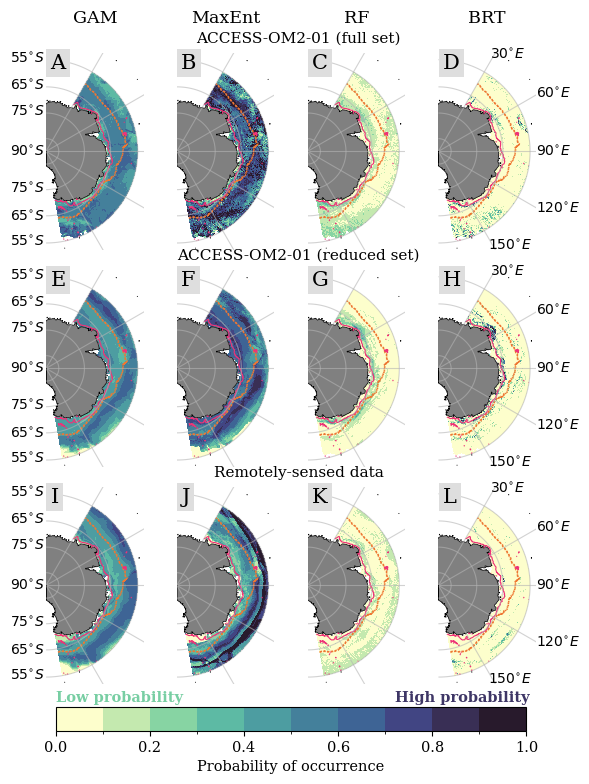

In [36]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [6.75, 10], constrained_layout = True)

#Setting levels for colorbar
levels = np.arange(0, 1.1, 0.1)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10.5

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Creating counter for plotting loop
#Defining SDM algorithms
SDM = ['GAM', 'MaxEnt', 'RF', 'BRT']

#Defining datasets to be plotted
trained_by = ['ACCESS-OM2-01 (full set)', 'ACCESS-OM2-01 (reduced set)', 'Remotely-sensed data']

#Index to loop through each subplot
counter = zip(np.repeat(np.arange(0, len(trained_by)), len(SDM)), cycle(np.arange(0, len(SDM))))

#Create grid
gs = gridspec.GridSpec(nrows = len(trained_by), ncols = len(SDM), wspace = 0., hspace = 0.1)

#Initiliase dictionary to store axes
ax = {}

#Creating plot using loop
for i, j in counter:
    ax[i, j] = fig.add_subplot(gs[i, j], projection = projection)
    #Select data based on column index
    if i == 0:
        da = mod.December
    elif i == 1:
        da = mod_match_obs.December
    elif i == 2:
        da = obs.December
    #Plot maps
    p1 = da.isel(model = j).plot.pcolormesh(ax = ax[i, j], colors = cm.cm.deep, 
                                            levels = levels, add_colorbar = False,
                                            transform = ccrs.PlateCarree())
    ice_10.sel(month = 12).plot.contour(levels = [0], colors = '#ee7733', linewidths = 1.1,
                                        ax = ax[i, j], linestyles = 'dotted',
                                        transform = ccrs.PlateCarree(), add_colorbar = False)
    bathy_1000.plot.contour(levels = [0], colors = '#ee3377', ax = ax[i, j], linewidths = 0.75,
                      transform = ccrs.PlateCarree(), add_colorbar = False)
    if j == 0:
        #Adding gridline labels - latitudes - First column only
        plt.text(-0.37, 0.95, '$55^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.81, '$65^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.68, '$75^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.48, '$90^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.29, '$75^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.15, '$65^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.02, '$55^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
    elif j == len(trained_by):
        #Adding gridline labels - longitudes - Last column only
        plt.text(0.53, 0.97, '$30^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.77, '$60^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.48, '$90^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.19, '$120^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(0.51, 0., '$150^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)

    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i, j].spines.values()]
    #Drawing gridlines
    gl = ax[i, j].gridlines(crs = ccrs.PlateCarree(), draw_labels = False, y_inline = False, 
                            color = "#b4b4b4", alpha = 0.6)
    gl.ylocator = mticker.FixedLocator([-55, -65, -75, -85])
    
    #Set titles for each map
    if i == 0:
        ax[i, j].set_title(f'{SDM[j]}\n', y = 1.01)
    if j == 1:
         ax[i, j].text(1.25, 1.07, f'{trained_by[i]}', horizontalalignment = 'center', 
                       fontsize = 11, verticalalignment = 'center', 
                       transform = ax[i, j].transAxes)
    
#Add land
[ax[a].add_feature(land_50m) for a in ax]
#Set extent shown in map
[ax[a].set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree()) for a in ax]

#Colorbar settings
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.03, label = 'Probability of occurrence')

#Add labels to improve readability
#Get colormap to extract colors for labels
cmap = plt.get_cmap(cm.cm.deep)
cb.ax.text(0., 1.25, 'Low probability', color = cmap(0.25), fontweight = 'bold')
cb.ax.text(0.72, 1.25, 'High probability', color = cmap(0.85), fontweight = 'bold')

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:(len(trained_by)*len(SDM))]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.045, .92, labels[i], transform = ax[a].transAxes, fontsize = 'x-large', 
               bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
plt.savefig('../SDM_outputs/December_results.tif', dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Plotting ensemble results and crabeater locations

## Load all crabeater sightings

In [33]:
#Load crabeaters data for the Southern Ocean
seals_all = pd.read_csv('../Biological_Data/All_sources_clean_data_MEASO.csv')

#Keep data for the Indian sectors and for time of interest
seals_ind = seals_all[(seals_all.sector.str.contains('Indian')) & (seals_all.year >= 1981) & (seals_all.year <= 2013) & (seals_all.month >= 11)]
#Ccheck results
seals_ind.head()

,Unnamed: 0,event_date,latitude,longitude,number_individuals,basis_record,source,year,month,season_year,life_stage,decade,geometry,index_right,name,sector,zone,fill,LongName
4253,4258,1996-11-15T00:00:00Z,-61.429,95.982,1,MACHINE_OBSERVATION,GBIF_AADC_ARGOS,1996,11,autumn,weaning,1990,POINT (95.982 -61.429),9,CIA,Central Indian,Antarctic,#FFFFFFFF,Central Indian Antarctic
4254,4259,1998-11-24T00:00:00Z,-64.009,111.518,1,MACHINE_OBSERVATION,GBIF_AADC_ARGOS,1998,11,autumn,weaning,1990,POINT (111.518 -64.009),9,CIA,Central Indian,Antarctic,#FFFFFFFF,Central Indian Antarctic
4255,4260,1994-11-12T00:00:00Z,-66.373,64.901,1,MACHINE_OBSERVATION,GBIF_AADC_ARGOS,1994,11,autumn,weaning,1990,POINT (64.901 -66.373),9,CIA,Central Indian,Antarctic,#FFFFFFFF,Central Indian Antarctic
4256,4261,1997-11-17T00:00:00Z,-61.304,103.208,1,MACHINE_OBSERVATION,GBIF_AADC_ARGOS,1997,11,autumn,weaning,1990,POINT (103.208 -61.304),9,CIA,Central Indian,Antarctic,#FFFFFFFF,Central Indian Antarctic
4258,4263,1997-11-15T00:00:00Z,-62.298,104.175,1,MACHINE_OBSERVATION,GBIF_AADC_ARGOS,1997,11,autumn,weaning,1990,POINT (104.175 -62.298),9,CIA,Central Indian,Antarctic,#FFFFFFFF,Central Indian Antarctic


In [44]:
#Create dictionaries with model ensembles for each month
nov_ensemble = {'ACCESS-OM2-01 (full set)': mod.November.sel(model = 'Ensemble'),
                'ACCESS-OM2-01 (reduced set)': mod_match_obs.November.sel(model = 'Ensemble'), 
                'Observations': obs.November.sel(model = 'Ensemble')} 

dec_ensemble = {'ACCESS-OM2-01 (full set)': mod.December.sel(model = 'Ensemble'),
                'ACCESS-OM2-01 (reduced set)': mod_match_obs.December.sel(model = 'Ensemble'), 
                'Observations': obs.December.sel(model = 'Ensemble')}

In [45]:
#Calculating threshold for SDM ensemble
nov_ensemble_mask = {'ACCESS-OM2-01 (full set)': bin_mod.November,
                     'ACCESS-OM2-01 (reduced set)': bin_mod_match_obs.November, 
                     'Observations': bin_obs.November}

dec_ensemble_mask = {'ACCESS-OM2-01 (full set)': bin_mod.December,
                     'ACCESS-OM2-01 (reduced set)': bin_mod_match_obs.December, 
                     'Observations': bin_obs.December}

/jobfs/145569806.gadi-pbs/ipykernel_2697537/1621703548.py:106: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../SDM_outputs/Ensemble_results_binary.tif', dpi = 300, bbox_inches = 'tight',
/jobfs/145569806.gadi-pbs/ipykernel_2697537/1621703548.py:106: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../SDM_outputs/Ensemble_results_binary.tif', dpi = 300, bbox_inches = 'tight',
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


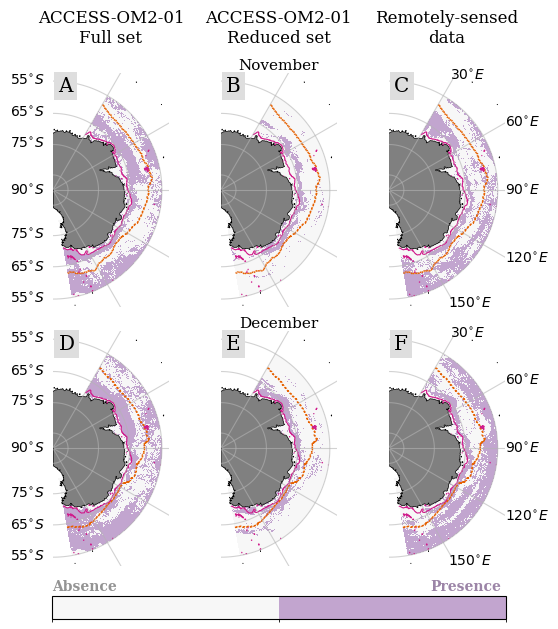

In [46]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [6.5, 8], constrained_layout = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Defining datasets to be plotted
trained_by = ['ACCESS-OM2-01 (full set)', 'ACCESS-OM2-01 (reduced set)', 
              'Observations']
months = ['November', 'December']

#Index to loop through each subplot
counter = zip(np.repeat(np.arange(0, len(months)), len(trained_by)), 
              cycle(np.arange(0, len(trained_by))))

#Create grid
gs = gridspec.GridSpec(nrows = len(months), ncols = (len(trained_by)), wspace = 0.,
                       hspace = 0.1)

#Initiliase dictionary to store axes
ax = {}

#Creating plot using loop
for i, j in counter:
    ax[i, j] = fig.add_subplot(gs[i, j], projection = projection)
    #Select data based on column index
    if i == 0:
        da = nov_ensemble_mask
        ice = ice_10.sel(month = 11)
    else:
        da = dec_ensemble_mask
        ice = ice_10.sel(month = 12)
    #Plot maps
    p1 = da[trained_by[j]].plot.pcolormesh(ax = ax[i, j], levels = [0, 0.5, 1.1], 
                                           colors = ['#f7f7f7', '#c2a5cf'], add_colorbar = False, 
                                           transform = ccrs.PlateCarree())
    ice.plot.contour(levels = [0], colors = '#e66101', linewidths = 1.1, ax = ax[i, j], 
                     linestyles = 'dotted',transform = ccrs.PlateCarree(), add_colorbar = False)
    bathy_1000.plot.contour(levels = [0], colors = '#d01c8b', ax = ax[i, j], linewidths = 0.75,
                            transform = ccrs.PlateCarree(), add_colorbar = False)

    if j == 0:
        #Adding gridline labels - latitudes - First column only
        plt.text(-0.37, 0.95, '$55^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.81, '$65^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.68, '$75^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.48, '$90^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.29, '$75^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.15, '$65^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(-0.37, 0.02, '$55^{\circ}S$', transform = ax[i, j].transAxes, fontsize = 10)
    elif j == 2:
        #Adding gridline labels - longitudes - Last column only
        plt.text(0.53, 0.97, '$30^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.77, '$60^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.48, '$90^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(1, 0.19, '$120^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)
        plt.text(0.51, 0., '$150^{\circ}E$', transform = ax[i, j].transAxes, fontsize = 10)

    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i, j].spines.values()]
    #Drawing gridlines
    gl = ax[i, j].gridlines(crs = ccrs.PlateCarree(), draw_labels = False, y_inline = False, 
                            color = "#b4b4b4", alpha = 0.6)
    gl.ylocator = mticker.FixedLocator([-55, -65, -75, -85])

    #Set titles for each map
    col_names = ['ACCESS-OM2-01\nFull set', 'ACCESS-OM2-01\nReduced set', 'Remotely-sensed\ndata']
    if i == 0:
        ax[i, j].set_title(f'{col_names[j]}\n', y = 1.01)
    if j == 1:
        ax[i, j].text(0.5, 1.03, f'{months[i]}', horizontalalignment = 'center', 
                       fontsize = 11, verticalalignment = 'center', 
                       transform = ax[i, j].transAxes)

#Add land
[ax[a].add_feature(land_50m) for a in ax]
#Set extent shown in map
[ax[a].set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree()) for a in ax]

#Colorbar settings
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.05, ticks = mticker.FixedLocator([]))
#Adding labels to colorbar
cb.ax.text(0., 1.25, 'Absence', color = '#949494', fontweight = 'bold')
cb.ax.text(0.9, 1.25, 'Presence', color = '#9c85a7', fontweight = 'bold')
#Removing ticks and colorbar text
cb.set_ticks([])
cb.ax.tick_params(size = 0)

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:(len(trained_by)*len(months))]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.047, .92, labels[i], transform = ax[a].transAxes, fontsize = 'x-large', 
               bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
plt.savefig('../SDM_outputs/Ensemble_results_binary.tif', dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Plotting crabeater seals and background locations

## Loading crabeater data

In [16]:
seals = pd.read_csv('../Environmental_Data/mod-match-obs_env_pres_bg_20x_Indian_weaning.csv')
seals.head()

,year,month,xt_ocean,yt_ocean,presence,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m,SIC,SST_degC,lt_pack_ice,dist_ice_edge_km
0,1998,11,75.85,-69.113,1,89.937,-492.145,130.290,628.583,0.649964,-1.794739,0.595238,-1007.829786
1,1998,11,75.35,-69.028,1,89.651,-481.137,117.409,729.212,0.681497,-1.801086,0.630952,-996.341423
2,1996,11,76.05,-68.986,1,89.957,-479.088,119.262,771.083,0.630009,-1.641327,0.595238,-945.316770
3,1998,11,75.45,-68.606,1,89.725,-434.549,71.716,657.067,0.777837,-1.816406,0.630952,-950.011791
4,1998,11,75.35,-68.395,1,89.720,-410.830,47.949,578.417,0.949461,-1.854187,0.630952,-926.231709


## Loading ocean fronts shapefile

In [17]:
#Ocean fronts in the Southern Ocean
SACC = gp.read_file('/g/data/vf71/la6889/GIS_DataBase/Shapefiles/Southern Ocean Fronts/SouthernOceanFronts.shp')
#Selecting relevant shapes
SACC = SACC[SACC.NAME.str.contains('boundary')]
#Defining East Antarctica boundaries
EA_box = gp.GeoDataFrame([1], geometry = [box(495522, -3333134.03, 3299207.53, 2833134.03)], crs = 3031)
#Clipping to East Antarctica
SACC = SACC.clip(EA_box)

#Define projection to south polar stereographic
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

## Plotting figure

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/geopandas/plotting.py:480: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  ax.figure.canvas.draw_idle()
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/geopandas/plotting.py:480: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  ax.figure.canvas.draw_idle()
/jobfs/145569806.gadi-pbs/ipykernel_2697537/2054890314.py:94: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../SDM_outputs/crabeater_locations_bg-pts.tif', dpi = 300,
/jobfs/145569806.gadi-pbs/ipykernel_2697537/2054890314.py:94: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../SDM_outputs/crabeater_loca

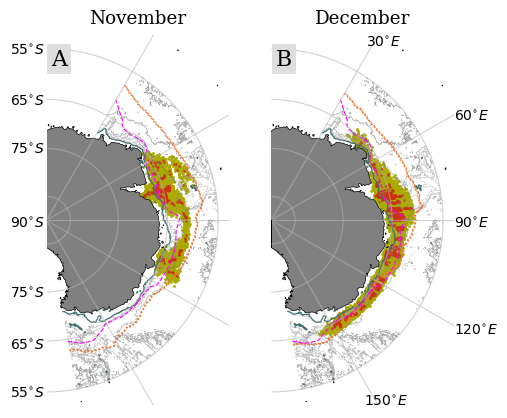

In [32]:
fig = plt.figure(figsize = [5.8, 4.8], constrained_layout = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11 

#Setting levels for deep depth contours (>2000m)
levels = np.arange(2000, 6000, 1000)

#Colormaps for bathymetry
my_map_d = mcolors.LinearSegmentedColormap.from_list('my_colormap', 
                                          cm.cm.gray_r(np.linspace(0.3, 0.6, 128)))

#Creating labels 
months = ['November', 'December']

#Create grid - No space between plots
gs = gridspec.GridSpec(nrows = 1, ncols = 2, wspace = 0)

#Initiliase dictionary to store axes
ax = {}

#First panel - Background points
for i, m in enumerate([11, 12]):
    ax[i] = fig.add_subplot(gs[i], projection = projection)
    #Plot deep areas (>=2000 m)
    bathy.plot.contour(ax = ax[i], transform = ccrs.PlateCarree(), 
                            levels = levels, cmap = my_map_d,
                            linewidths = 0.4, alpha = 0.6)
    #Get seal data for month
    mth = seals[(seals.month == m)]
    #Plot background points
    mth[(mth.presence == 0)].plot.scatter(x = 'xt_ocean', y = 'yt_ocean', s = 1,
                                          c = '#aaaa00', ax = ax[i], 
                                          transform = ccrs.PlateCarree())
    #Plot crabeater locations
    mth[(mth.presence == 1)].plot.scatter(x = 'xt_ocean', y = 'yt_ocean', s = 0.5,
                                          c = '#cc3311', ax = ax[i], 
                                          transform = ccrs.PlateCarree())
    #Plot bathymetry contours for shallower areas (1000m)
    bathy.plot.contour(ax = ax[i], transform = ccrs.PlateCarree(), 
                            levels = [1000], colors = ['#407072'],
                            linewidths = 0.85)
    
    ice_10[i].plot.contour(levels = [0], colors = '#ee7733', 
                                        linewidths = 1.1, ax = ax[i], linestyles = 'dotted',
                                        transform = ccrs.PlateCarree(), add_colorbar = False)

    #Plot southern boundary of ACC
    SACC.plot(ax = ax[i], ls = '--', lw = 0.85, cmap = mpl.colormaps['spring'])
    
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    
    #Keep axis labels on left only
    gl = ax[i].gridlines(crs = ccrs.PlateCarree(), draw_labels = False, y_inline = False, 
                                color = "#b4b4b4", alpha = 0.6)
    gl.ylocator = mticker.FixedLocator([-55, -65, -75, -85])

    if i == 0:
        #Adding gridline labels - latitudes - First column only
        plt.text(-0.20, 0.95, '$55^{\circ}S$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(-0.20, 0.81, '$65^{\circ}S$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(-0.20, 0.68, '$75^{\circ}S$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(-0.20, 0.48, '$90^{\circ}S$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(-0.20, 0.29, '$75^{\circ}S$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(-0.20, 0.15, '$65^{\circ}S$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(-0.20, 0.02, '$55^{\circ}S$', transform = ax[i].transAxes, fontsize = 10)
    else:
        #Adding gridline labels - longitudes - Last column only
        plt.text(0.52, 0.97, '$30^{\circ}E$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(1, 0.77, '$60^{\circ}E$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(1, 0.48, '$90^{\circ}E$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(1, 0.19, '$120^{\circ}E$', transform = ax[i].transAxes, fontsize = 10)
        plt.text(0.51, 0., '$150^{\circ}E$', transform = ax[i].transAxes, fontsize = 10)

    #Set titles for each map
    ax[i].set_title(f'{months[i]}', y = 1.01)

    #Add land and coastline
    ax[i].add_feature(land_50m)

    #Set extent shown in map
    ax[i].set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

    #Getting the alphabet in upper case to label plots
    labels = string.ascii_uppercase[0:2]
    #Apply labels only to plots, not colorbars
    ax[i].text(0.025, .92, labels[i], transform = ax[i].transAxes, 
               fontsize = 'x-large', bbox = dict(facecolor = '#dedede',
                                                 edgecolor = 'none', pad = 3.0))

#Saving figure
plt.savefig('../SDM_outputs/crabeater_locations_bg-pts.tif', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)